## Imports

In [1]:
import numpy as np
import quantities
import copy

import sys
import os 
import warnings
import numpy as np

pkg_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(pkg_path)

import shtmbss2.addsrc


from matplotlib import pyplot as plt
from tabulate import tabulate
from abc import ABC

import shtmbss2.brainscales2.patches
from shtmbss2.brainscales2.config import *
from shtmbss2.brainscales2.patches import patch_pynn_calibration
from shtmbss2.brainscales2.plasticity import PlasticityOnChip
from shtmbss2.core.logging import log
from shtmbss2.core.helpers import id_to_symbol
import shtmbss2.common.network as network
from shtmbss2.common.config import NeuronType, RecTypes
from shtmbss2.brainscales2.network import SHTMTotal
from shtmbss2.common.config import *
from shtmbss2.core.parameters import Parameters
from shtmbss2.brainscales2.hardware import hardware_initialization


from pynn_brainscales import brainscales2 as pynn
from pynn_brainscales.brainscales2 import Projection, PopulationView
from pynn_brainscales.brainscales2.populations import Population
from pynn_brainscales.brainscales2.standardmodels.cells import SpikeSourceArray
from pynn_brainscales.brainscales2.connectors import AllToAllConnector, FixedNumberPreConnector, OneToOneConnector
from pynn_brainscales.brainscales2.standardmodels.synapses import StaticSynapse
from pyNN.random import NumpyRNG
from dlens_vx_v3 import sta, halco, hal, lola

RECORDING_VALUES = {
    NeuronType.Soma: {RecTypes.SPIKES: "spikes", RecTypes.V: "v"},
    NeuronType.Dendrite: {RecTypes.SPIKES: "spikes", RecTypes.V: "v"},
    NeuronType.Inhibitory: {RecTypes.SPIKES: "spikes", RecTypes.V: "v"}
}

Could not load module 'colorlog'. Continuing logging without colored formatter.


## Configuration

In [2]:
runtime = 1
num_neurons = 2
spike_times_soma = [[0.01, 0.1], []]
spike_times_dend = [[], []]

## Load parameters

In [3]:
p = Parameters(network_type=SHTMTotal)
p.load_default_params()

In [4]:
patch_pynn_calibration(
            p.Calibration.padi_bus_dacen_extension,
            p.Calibration.correlation_amplitude,
            p.Calibration.correlation_time_constant,
        )

In [5]:
# TODO: remove once grenade supports dense inter-population-view projections
neuronPermutation = []
alphabet_size = 1
num_neurons_per_symbol = 2
for a in range(alphabet_size):
    # dendrites
    for i in range(num_neurons_per_symbol):
        neuronPermutation.append((a * num_neurons_per_symbol + i) * 2)
for a in range(alphabet_size):
    # somas
    for i in range(num_neurons_per_symbol):
        neuronPermutation.append((a * num_neurons_per_symbol + i) * 2 + 1)
for i in range(alphabet_size * num_neurons_per_symbol * 2, 512):
    neuronPermutation.append(i)

hardware_initialization(neuronPermutation=neuronPermutation)

INFO  07:32:43,326  demo_helpers Using setup hxcube7fpga0chip57_1


## Define Neurons

In [6]:
# Multi-Compartment
dendrites = pynn.Population(num_neurons, pynn.cells.CalibHXNeuronCuba(
    # tau_m=p.Neurons.Excitatory.tau_m[0],
    # tau_syn_I=p.Neurons.Excitatory.tau_syn_I[0],
    # tau_syn_E=p.Neurons.Excitatory.tau_syn_E[0],
    # v_rest=p.Neurons.Excitatory.v_rest[0],
    # v_reset=p.Neurons.Excitatory.v_reset[0],
    # v_thresh=p.Neurons.Excitatory.v_thresh[0],
    # tau_refrac=p.Neurons.Excitatory.tau_refrac[0],
))

somas = pynn.Population(num_neurons, pynn.cells.CalibHXNeuronCuba(
    tau_m=p.Neurons.Excitatory.tau_m[1],
    tau_syn_I=p.Neurons.Excitatory.tau_syn_I[1],
    tau_syn_E=p.Neurons.Excitatory.tau_syn_E[1],
    v_rest=p.Neurons.Excitatory.v_rest[1],
    v_reset=p.Neurons.Excitatory.v_reset[1],
    v_thresh=p.Neurons.Excitatory.v_thresh[1],
    tau_refrac=p.Neurons.Excitatory.tau_refrac[1],
))

somas.record([RECORDING_VALUES[NeuronType.Soma][RecTypes.SPIKES]])
dendrites.record([RECORDING_VALUES[NeuronType.Dendrite][RecTypes.SPIKES]])


# External
neurons_ext_soma = Population(num_neurons, SpikeSourceArray())
neurons_ext_soma.set(spike_times=spike_times_soma)

neurons_ext_dendrite = Population(num_neurons, SpikeSourceArray())
neurons_ext_dendrite.set(spike_times=spike_times_dend)

In [7]:
pynn.preprocess()

for i in range(len(dendrites)):
    dendrites.actual_hwparams[i].multicompartment.enable_conductance = True
    dendrites.actual_hwparams[i].multicompartment.i_bias_nmda = 120
    dendrites.actual_hwparams[i].multicompartment.connect_soma_right = True
    dendrites.actual_hwparams[i].refractory_period.reset_holdoff = 0

for i in range(len(somas)):
    somas.actual_hwparams[i].multicompartment.connect_soma = True

/tmp/ipykernel_55879/4262919866.py:1: DeprecationWarning: Please use pyNN.run(None, pyNN.RunCommand.PREPARE)
  pynn.preprocess()
/srv/main-spack-instance-2402/spack/var/spack/environments/experimental/.spack-env/view/lib/python3.8/site-packages/calix/spiking/correlation_measurement.py:603: RuntimeWarning: Mean of empty slice
  taus = np.nanmean(taus, axis=0)
/srv/main-spack-instance-2402/spack/var/spack/environments/experimental/.spack-env/view/lib/python3.8/site-packages/calix/spiking/correlation_measurement.py:575: RuntimeWarning: Mean of empty slice
  return np.nanmean(amplitudes, axis=0)


WARN  07:59:15,860  lib-rcf.OnDemandUpload.loop_upload Error while uploading: Unexpected peer disconnection.
WARN  07:59:15,885  lib-rcf.OnDemandUpload.loop_upload Error while uploading: Unexpected peer disconnection.
WARN  07:59:16,901  lib-rcf.OnDemandUpload.loop_upload Error while uploading: Unable to establish network connection. Connection refused
WARN  07:59:17,912  lib-rcf.OnDemandUpload.loop_upload Error while uploading: Unable to establish network connection. Connection refused
WARN  07:59:18,936  lib-rcf.OnDemandUpload.loop_upload Error while uploading: Unexpected peer disconnection.
WARN  07:59:19,958  lib-rcf.OnDemandUpload.loop_upload Error while uploading: Unexpected peer disconnection.


## Define Connections

In [8]:
from pynn_brainscales.brainscales2.connectors import OneToOneConnector

# External to Soma
ext_to_soma = Projection(
                    neurons_ext_soma,
                    somas,
                    OneToOneConnector(),
                    synapse_type=StaticSynapse(weight=p.Synapses.w_ext_exc),
                    receptor_type=p.Synapses.receptor_ext_exc)

# External to Dendrite
ext_to_dend = Projection(
                    neurons_ext_dendrite,
                    dendrites,
                    OneToOneConnector(),
                    synapse_type=StaticSynapse(weight=400),
                    receptor_type=p.Synapses.receptor_ext_exc)

# Soma to Dendrite (dummy)
soma_to_dend = Projection(
                    somas,
                    dendrites,
                    OneToOneConnector(),
                    synapse_type=StaticSynapse(weight=0),
                    receptor_type=p.Synapses.receptor_exc_exc)

## Run Emulation

In [9]:
pynn.run(runtime)

## Retrieve Data

### Spikes

In [10]:
spikes_dendrites = dendrites.get_data(RECORDING_VALUES[NeuronType.Dendrite][RecTypes.SPIKES]).segments[-1].spiketrains
print(f"Spikes (dendrites): {spikes_dendrites}")

spikes_somas = somas.get_data(RECORDING_VALUES[NeuronType.Soma][RecTypes.SPIKES]).segments[-1].spiketrains
print(f"Spikes (somas): {spikes_somas}")

Spikes (dendrites): [<SpikeTrain(array([], dtype=float64) * ms, [0.0 ms, 1.0 ms])>, <SpikeTrain(array([], dtype=float64) * ms, [0.0 ms, 1.0 ms])>]
Spikes (somas): [<SpikeTrain(array([0.013264, 0.103248]) * ms, [0.0 ms, 1.0 ms])>, <SpikeTrain(array([], dtype=float64) * ms, [0.0 ms, 1.0 ms])>]


## Plot Data

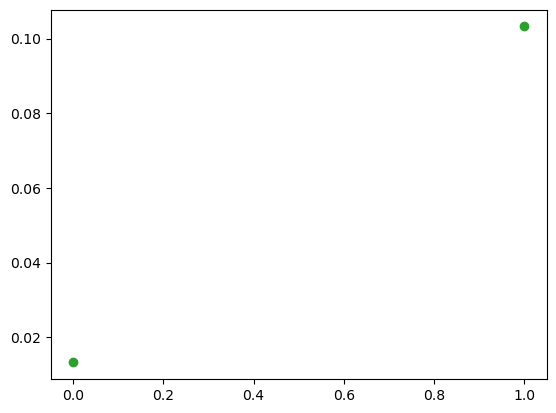

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

for i_neuron in range(num_neurons):
    plt.plot(spikes_dendrites[i_neuron], 'o')

for i_neuron in range(num_neurons):
    plt.plot(spikes_somas[i_neuron], 'o')

In [15]:
neuron_id=0
neuron_type=NeuronType.Dendrite
show_legend=False

pynn.reset()

rec_neurons_exc = pynn.PopulationView(dendrites, [neuron_id])
rec_neurons_exc.record([RECORDING_VALUES[neuron_type][RecTypes.V],
                             RECORDING_VALUES[neuron_type][RecTypes.SPIKES]])

pynn.run(runtime)

data_v = rec_neurons_exc.get_data("v").segments[-1].irregularlysampledsignals

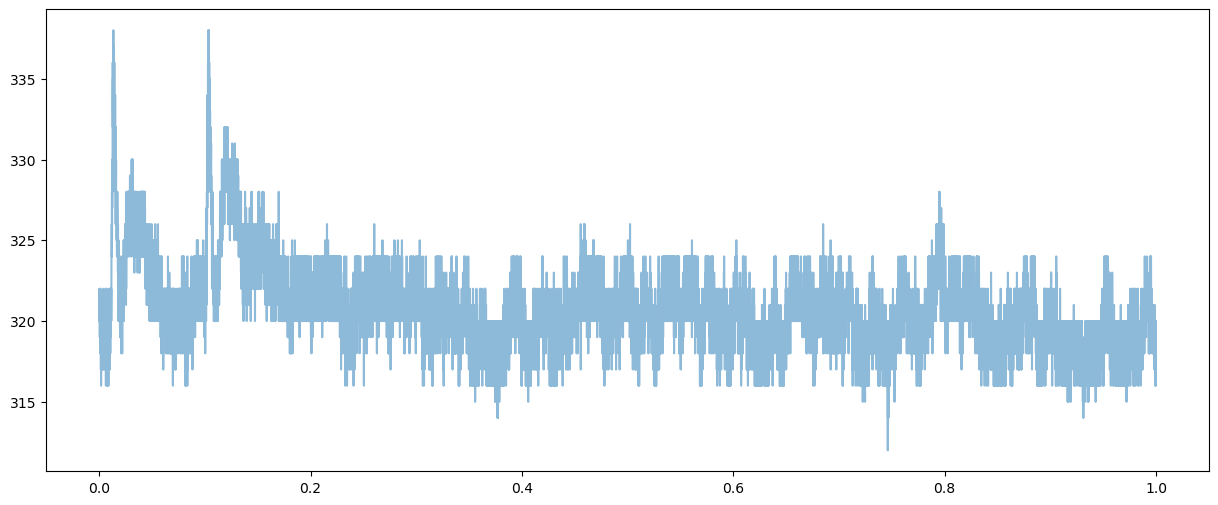

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(data_v[0].times, data_v[0], alpha=0.5)

## Reset PyNN

In [ ]:
pynn.reset()